# Shakespearean Text Generation using RNNs

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

## Download the dataset

In [2]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

/tmp/.keras/datasets/shakespeare.txt


## Analyze the dataset

In [3]:
# Reading the text file.
text = open(dataset_file_path, mode='r').read()

print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))

print(f'{len(vocab)} unique characters')
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the text data

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [6]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

In [7]:
print(char2index)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

In [10]:
text_as_int

array([18, 47, 56, ..., 45,  8,  0])

In [11]:
print(f'text_as_int length: {len(text_as_int)}')

text_as_int length: 1115394


In [12]:
# Print the first 15 characters of the original text and their integer representation
print(f'{text[:15]} --> {text_as_int[:15]}')

First Citizen:
 --> [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0]


## Create training sequences

In [13]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [14]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [15]:
# Generate batched sequences from the character dataset
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Get the number of sequences, which is the same as examples_per_epoch
sequence_count = len(list(sequences.as_numpy_iterator()))
print(f'Sequences count: {sequence_count}\n')

# Display examples of sequences
for item in sequences.take(5):
    print(''.join(index2char[item.numpy()]))

Sequences count: 11043

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 
are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k
now Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us ki
ll him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be d
one: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citi


In [16]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [17]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [18]:
# Map sequences to input and target text
dataset = sequences.map(split_input_target)

# The dataset size is the same as examples_per_epoch,
# but each element now has a length of `sequence_length`
# and not 'sequence_length + 1'
dataset_size = len(list(dataset.as_numpy_iterator()))
print(f'Dataset size: {dataset_size}')

Dataset size: 11043


In [19]:
# Retrieve one example from the dataset
for input_example, target_example in dataset.take(1):
    input_size = len(input_example.numpy())
    target_size = len(target_example.numpy())

    print(f'Input sequence size: {input_size}')
    print(f'Target sequence size: {target_size}\n')

    input_text = repr(''.join(index2char[input_example.numpy()]))
    target_text = repr(''.join(index2char[target_example.numpy()]))

    print(f'Input: {input_text}')
    print(f'Target: {target_text}')

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [20]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [21]:
# Iterate through the first five elements of input and target examples
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    input_char = repr(index2char[input_idx])
    target_char =repr( index2char[target_idx])

    print(f'Step {i:2d}')
    print(f'  input: {input_idx} ({input_char})')
    print(f'  expected output: {target_idx} ({target_char})')

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [22]:
# Batch size.
BATCH_SIZE = 64

# Set the buffer size for shuffling the dataset.
# TensorFlow's data pipeline is designed for potentially infinite sequences,
# so it uses a buffer to shuffle elements rather than shuffling the entire dataset in memory.
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [23]:
# Print the size of the batched dataset
batched_dataset_size = len(list(dataset.as_numpy_iterator()))
print(f'Batched dataset size: {batched_dataset_size}')

Batched dataset size: 172


In [24]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[20 13 25 ...  0 13 14]
 [58 43 50 ... 59 50  6]
 [44 47 58 ... 40 43 46]
 ...
 [18 18 10 ... 42 53 59]
 [52  1 13 ... 59 58 63]
 [ 1 52 53 ... 59 52 39]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[13 25 10 ... 13 14 30]
 [43 50 50 ... 50  6  0]
 [47 58 39 ... 43 46 43]
 ...
 [18 10  0 ... 53 59 40]
 [ 1 13 54 ... 58 63  1]
 [52 53 58 ... 52 39 42]], shape=(64, 100), dtype=int64)


In [25]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

# Model Building
## Hyperparameters

In [26]:
# Length of the vocabulary in characters.
vocab_size = len(vocab)

# Dimension of the embedding layer
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

# Number of samples per gradient update
# batch_size = 64

In [27]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    # Define a Sequential model
    model = tf.keras.Sequential()

    # Set the input layer with fixed batch size
    model.add(tf.keras.layers.Input(batch_shape=(batch_size, None)))

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    # LSTM layer with stateful=True and a GlorotNormal initializer
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    # Dense layer with output units equal to vocab size
    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [28]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, None, 256)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (64, None, 1024)            │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, None, 65)              │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

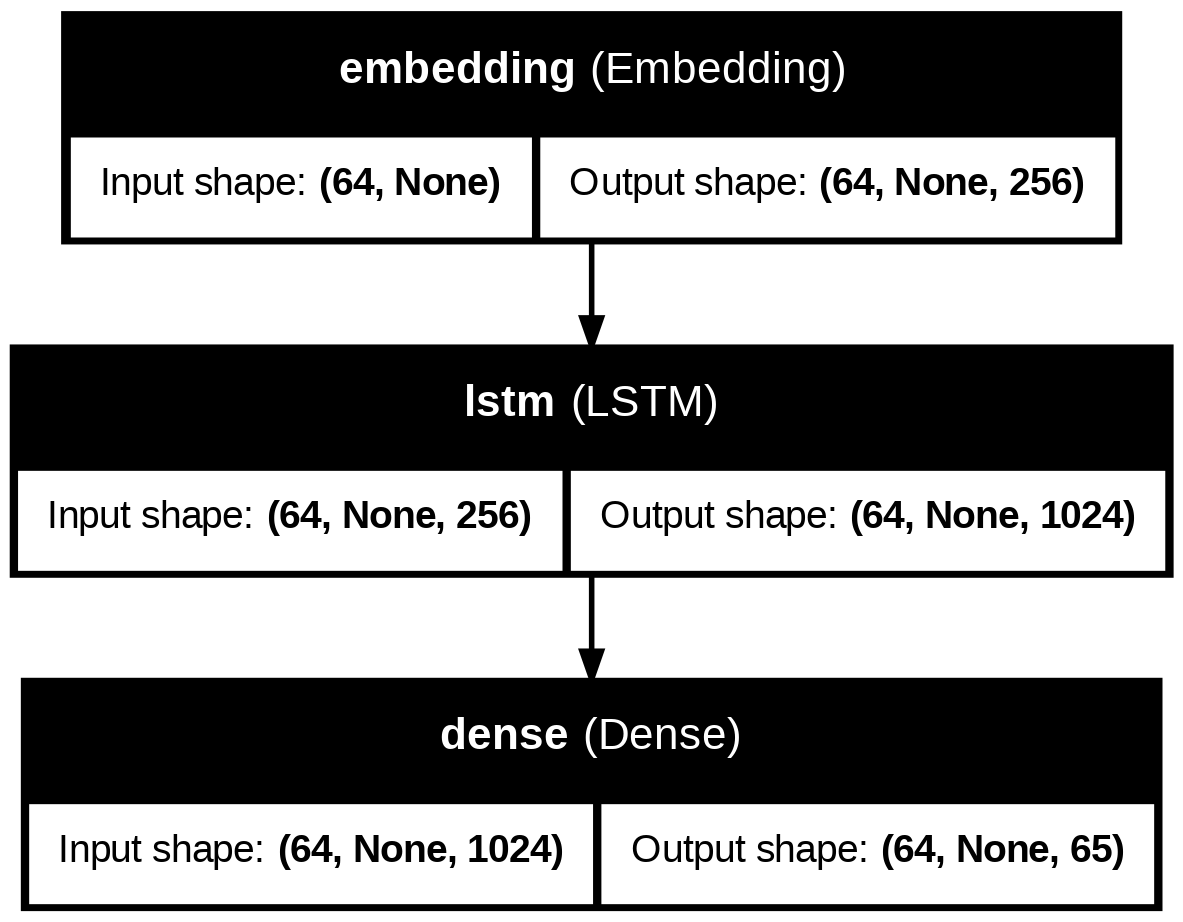

In [30]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Try the model

In [31]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [32]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-3.3136769e-03 -1.8216955e-03 -4.4506965e-03 -9.6264260e-04
  1.3516686e-03 -4.3478291e-03 -3.3204367e-03 -4.8723798e-03
 -8.0455130e-04  3.3995772e-03  3.0999419e-03 -8.9938578e-04
 -9.3025733e-03  2.6494870e-03  6.0682697e-03  1.8063136e-03
  2.8438068e-03 -4.9730563e-03  7.7216048e-04  3.5291386e-03
 -2.8528078e-04  5.8763768e-03 -1.5338142e-03  5.6031938e-03
  1.7908477e-03 -5.6365877e-03 -5.4445714e-03 -4.1985004e-03
  2.2727300e-03  1.0246054e-03 -4.3345070e-03 -3.0270455e-04
  2.6373642e-03 -1.2825216e-03  2.0898411e-03 -3.6836811e-04
 -8.3221169e-03  1.6993647e-03  4.4226772e-03  4.4572103e-06
  2.7378099e-03  3.7711624e-03 -3.8224093e-03  2.8337573e-03
 -3.7130071e-03  6.7760440e-04 -3.1746884e-03 -1.1740917e-03
  6.2958623e-04 -2.1350794e-03  4.1272305e-03 -2.7814067e-03
  3.4220580e-03 -9.5357513e-03 -4.1006296e-04  6.8000290e-03
  3.9745895e-03  7.5441715e-04  2.1849668e-03 -5.4619354e-03
  5.6177314e-04 -

In [33]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [34]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [35]:
sampled_indices

array([46, 19,  2, 42, 46, 36,  6, 10, 55, 33, 13, 11, 58, 48, 31, 39, 10,
       23, 29, 53, 41, 58,  1, 63,  5, 50, 39, 61, 40, 20, 16, 56, 11, 45,
       26, 17, 13, 10,  8,  0, 15,  8, 59, 12, 58, 46, 18, 33, 46, 29, 48,
       47, 28, 14, 56, 37, 49, 57, 32, 14, 30, 11, 24, 41, 19, 16, 12, 13,
       55, 15, 37, 50, 63, 44, 55, 60,  9, 40, 25, 28,  4, 25, 32,  3, 58,
        8, 18, 53, 38, 54, 36,  4,  8, 16, 39, 39, 41, 57, 10,  3])

In [36]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "lphos, and from thence have brought\nThe seal'd-up oracle, by the hand deliver'd\nOf great Apollo's pr"

Next char prediction:
 "hG!dhX,:qUA;tjSa:KQoct y'lawbHDr;gNEA:.\nC.u?thFUhQjiPBrYksTBR;LcGD?AqCYlyfqv3bMP&MT$t.FoZpX&.Daacs:$"


In [37]:
# Display predictions for the first 5 samples
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    input_char = index2char[input_idx]  # Get the character from input index
    predicted_char = index2char[sample_idx]  # Get the predicted character

    print(f'Prediction {i:2d}')
    print(f'  input: {input_idx} ({repr(input_char)})')
    print(f'  next predicted: {sample_idx} ({repr(predicted_char)})')

Prediction  0
  input: 50 ('l')
  next predicted: 46 ('h')
Prediction  1
  input: 54 ('p')
  next predicted: 19 ('G')
Prediction  2
  input: 46 ('h')
  next predicted: 2 ('!')
Prediction  3
  input: 53 ('o')
  next predicted: 42 ('d')
Prediction  4
  input: 57 ('s')
  next predicted: 46 ('h')


# Model Training

In [38]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=logits, from_logits=True)

In [39]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.173642


In [40]:
# Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss=loss)

### Configure checkpoints

In [41]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

### Execute the training

In [42]:
EPOCHS = 50

In [43]:
history = model.fit(x=dataset, epochs=EPOCHS, callbacks=callbacks_list)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.8661
Epoch 1: loss improved from inf to 2.41399, saving model to weights-improvement-01-2.4140.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 2.8634
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.8563
Epoch 2: loss improved from 2.41399 to 1.78012, saving model to weights-improvement-02-1.7801.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 1.8558
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.6016
Epoch 3: loss improved from 1.78012 to 1.56745, saving model to weights-improvement-03-1.5674.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 1.6014
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.4751
Epoch 4: loss improved from 1.56745 to 1.46019, saving model to weights-improvement-04-1.4602.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - loss: 1.4751
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.4016
Epoch 5: loss improved from 1.46

In [44]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

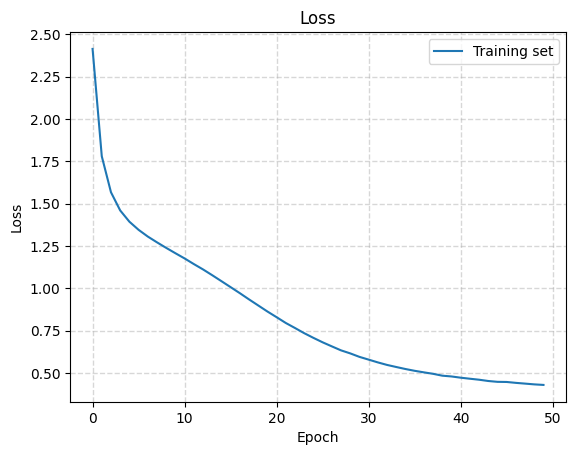

In [45]:
render_training_history(history)

# Building and Training a GRU model

In [71]:
# define the checkpoint
filepath2 = "weights-improvement-gru-{epoch:02d}-{loss:.4f}.keras"
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list2 = [checkpoint2]

In [72]:
def build_gru_model(vocab_size, embedding_dim, rnn_units, batch_size):
    # Define a Sequential model
    model = tf.keras.Sequential()

    # Set the input layer with fixed batch size
    model.add(tf.keras.layers.Input(batch_shape=(batch_size, None)))

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    # GRU layer with stateful=True and a GlorotNormal initializer
    model.add(tf.keras.layers.GRU(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    # Dense layer with output units equal to vocab size
    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [73]:
# Instantiate the GRU model
gru_model = build_gru_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [74]:
gru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (64, None, 256)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (64, None, 1024)            │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (64, None, 65)              │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

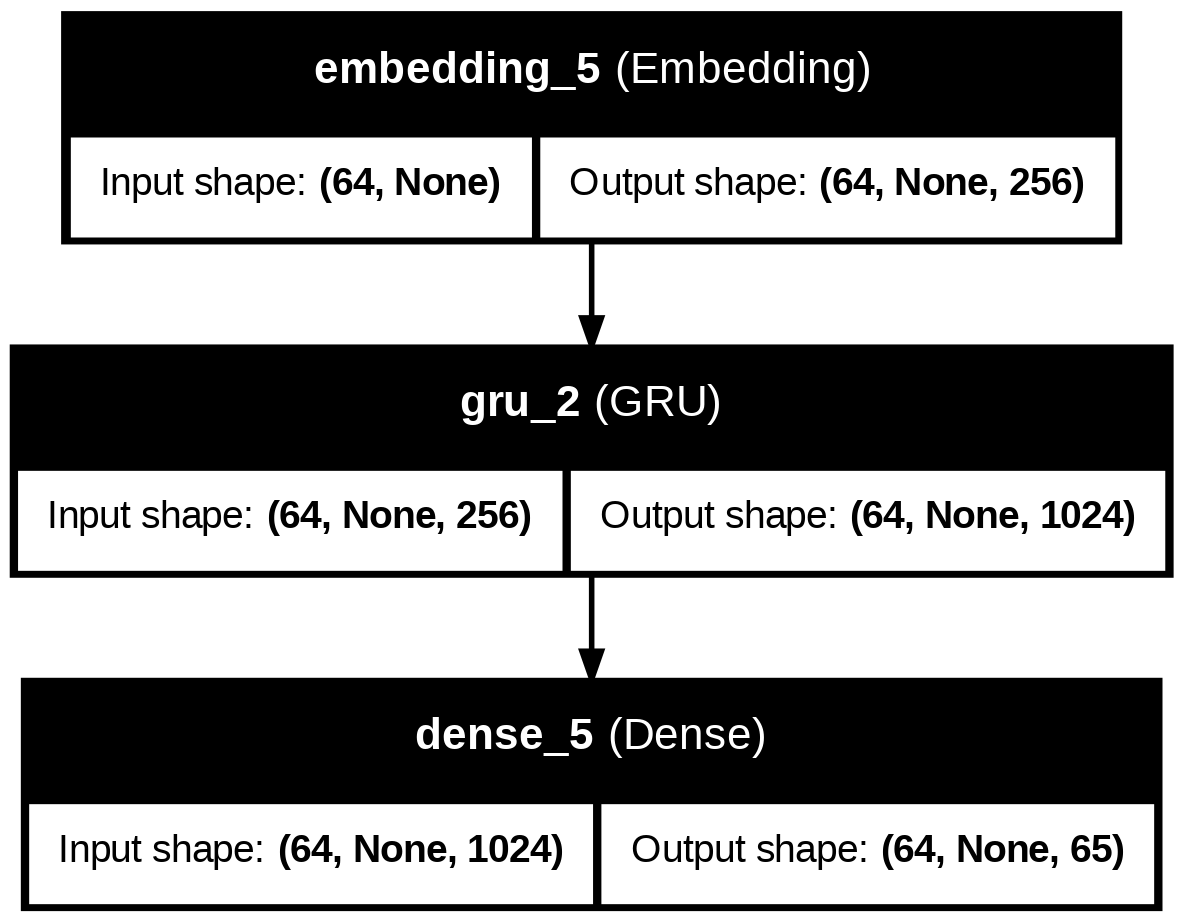

In [78]:
tf.keras.utils.plot_model(
    gru_model,
    show_shapes=True,
    show_layer_names=True,
)

In [75]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss2(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=logits, from_logits=True)

In [76]:
# Compile the GRU model
adam_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
gru_model.compile(optimizer=adam_optimizer2, loss=loss2)

In [77]:
# Train the GRU model
history_gru = gru_model.fit(x=dataset, epochs=EPOCHS, callbacks=callbacks_list2, verbose=1)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.0951
Epoch 1: loss improved from inf to 2.50778, saving model to weights-improvement-01-2.5078.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 3.0917
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.9178
Epoch 2: loss improved from 2.50778 to 1.84165, saving model to weights-improvement-02-1.8417.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 1.9173
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.6505
Epoch 3: loss improved from 1.84165 to 1.61228, saving model to weights-improvement-03-1.6123.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 1.6503
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.5092
Epoch 4: loss improved from 1.61228 to 1.49205, saving model to weights-improvement-04-1.4920.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 1.5091
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.4267
Epoch 5: loss improved from 1.49

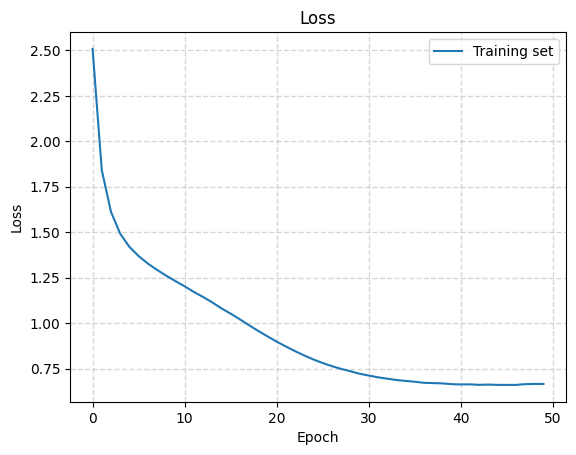

In [79]:
render_training_history(history_gru)

# Text Generation
* In this section, we will generate text using the trained RNN model. We'll start with a given string and generate a specified number of characters based on the model's predictions.

### Restoring the Model
* First, we need to restore the model from the latest checkpoint to use the trained weights for text generation.
* We will also build the model to accept a batch size of 1 for our predictions.

In [47]:
simplified_batch_size = 1

# build the model again with the simplified batch size
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=simplified_batch_size)

# build the model with the expected input shape
model.build(tf.TensorShape([simplified_batch_size, None]))

# load the weights
filename = "/content/weights-improvement-50-0.4297.keras"
model.load_weights(filename)

In [48]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, None, 256)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, None, 1024)             │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, None, 65)               │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

# Text Generation

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

### Text Generation Function
The `generate_text` function generates text using the trained model. It takes a start string and the number of characters to generate.
- **Input**:
  - `model`: The trained RNN model.
  - `start_string`: The string to start generating from.
  - `num_generate`: The total number of characters to generate.
  - `temperature`: Controls the randomness of predictions. Lower values make the model more conservative.
   - Low temperatures results in more predictable text.
   - Higher temperatures results in more surprising text.
   - Experiment to find the best setting.

In [49]:
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Reset the states of the recurrent layers within the model
    for layer in model.layers:
       if hasattr(layer, 'reset_states'):
           layer.reset_states()

    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [50]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: ", temperature=1))

ROMEO: for that I read themselves
Like rags that should endure us broke them more
To swift be itself to be brief wash'd all;
And vouch it to the heavy caused thou strikest me sore wither'd have I in her through they us.

Second Keeper:
But, as it is, Caius Marcius: there my hearts!

TYBALTH:
Which so hang'd up thy friend
Is my poor trade, flesh with the English peers,
That raise his body to the cushion of his mother;
Cry 'Centeracted the king's house, Marcius, whose circums
In he remembering whom we think they take upon
me; I will one nor enemy; you home to crow;
And all comforts are hollow'd friendships.

SOMERSET:
A sixt of all, he's more to purge her forth,
But 'twas the wise for which he play'd it stankedowe a thousand-fold more less;
Therefore die Richard that struck upon thyself?

JULIET:
Farewell! good Pompey. is good night, I would have head
A man well known that we mean to lo;
And he shall scarce call thus, for it good
And be in char he hath shortly of the fire
Of every we to 

In [51]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"BRUTUS: ", temperature=0.8))

BRUTUS: 'Glay siture from such great majesty,
His statutes and to fear. Now when my soul is an old proportion of your own dreads?

BUCKINGHAM:
No, by my troth, my lord?

KING RICHARD II:
So proud that Angelo hath made to do this wrong.

KING HENRY VI:
Infusing on the old pantal of you
To plant unrightful kings and state of friends.
Now jound, some large enough to be my heir.
What you will have, I'll give, prepared to die.

ISABELLA:
Ay, with favour.

SICINIUS:
Does the urged that we may foreign these poor stars,
An one of you so pale?

O both of the four substitution.

First Lord:
You must not endure him.

ANGELO:
We will make that have more time to come by thy brow
And take it on the ground, which I would I cannot,--
With teach my trust that was hither come so far,
And jocund day befall'd, I would not force the world now with a man
That like a new-hearter of a full as bold in them,
But in the streets, the eyes would do not,
Before you find you out at gates:
So many thoughts of nis sho

In [81]:
simplified_batch_size = 1

# build the model again with the simplified batch size
gru_model = build_gru_model(vocab_size, embedding_dim, rnn_units, batch_size=simplified_batch_size)

# build the model with the expected input shape
gru_model.build(tf.TensorShape([simplified_batch_size, None]))

# load the weights
filename = "/content/weights-improvement-47-0.6606.keras"
gru_model.load_weights(filename)

In [82]:
gru_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (1, None, 256)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (1, None, 1024)             │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, None, 65)               │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

# Generate text with GRU model

In [83]:
# Generate the text with default temperature (1.0).
print(generate_text(gru_model, start_string=u"ROMEO: ", temperature=1))

ROMEO: come Sigor, thou
wilt quench me here lies valiant is all:
I never see the brotor from the hiltest chueack,
And spoke of her and our innatural deaths:
Why after I have kill'd him; we will abtor thee.

CLAUDIO:
Perhaps you have the pence.

GREMIO:
But how past eleven did for the middle and our people
With all my heart, the letter he enough;
But loves not so forfier:

HENRY PERCY:
No rage to make voices. The ne'er was respected heir,
And seen the child-ship will we fight.

LADY ANNE:
Some dunatou I did take these walse camest thou beet,
On me, where away are to't, Warwick,
That fill aid, bring him dead, with
such'd out and seeks that thou so, 'what I think, our city respect,
Which and tumbling summer's well-meaning.

MIRANDA:
O, that's the unwilligency; she's run as limit:
Be patient, gentle Nept to Bianca make him rascal frown,
The brother body shows,
That seest thy spoil: suffer'd, thou never affright?

HESS OF YORK:
Who multitude, here's furbish woman,
Hath let me bear it. As th

In [84]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(gru_model, start_string=u"BRUTUS: ", temperature=0.8))

BRUTUS: O prince, is an earthly modest, some pardon
Are of themselves, that to the palace gall'd in the hour,
For she is spoken of my country's light,
Seldoms, and Romeo did before you go;
And now I fear some ill: Signior Placent in the gove; next, that would have held unto the king.

Second Citizen:
Marry, we will bestrew them, and I hate;
But this alliance may shoot?
O, thou look'st on my journey, and must die with me,
But my true love me well, good follow.

First Senator:
D'd you y, but surely.

Second Servant:
O, these are the music of Time.

SICINIUS:
For the marance and the greater fierce hands no foot,
As if the rest were your ancess.
You are treacher! and he shall turn of you;
And with shall prove false friends; him not am I king!
Edward the man, slow, go with me;
Who now came I him in the best, a beggar.

MENENIUS:
Not to him, and leapthee.

CORIOLANUS:
Cut me not, something that is not the king, and rene
Be satisfied, and beguit home:
Now come too lightnfolk from Pardon for i

## Save the model

In [85]:
model.save('shakespeare_text_gen_lstm.keras')

In [86]:
gru_model.save('shakespeare_text_gen_gru.keras')